###Last Update: 
Mar 22, 2021. Added Feature Importance score to RF results for 10 days kdd data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# -*- coding: utf-8 -*-
"""
Created on 12-05-2019

@author: Xin Huang
"""

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop


from sklearn.model_selection import train_test_split
import numpy as np

#from google.colab import drive
#drive.mount('content/')
# data = np.load('Sat_data_small.npz')
# data = np.load('/content/content/My Drive/Colab Notebooks/Sat_data_small.npz')
# data = np.load('/content/content/My Drive/Colab Notebooks/kddworkshop/train7.npz')
data = np.load('/content/drive/My Drive/kddworkshop/fulldata/train10.npz')
#data = np.load('/content/drive/My Drive/Domain Adaptation Test/train10.npz')

# passive = 1
#load common data
latlon = data['latlon']
iff = data['iff']

X_v = data['viirs']
Y_v = data['label']
print ('X_v shape:');
print (X_v.shape);

inds_v,vals_v = np.where(Y_v>0)
Y_v = Y_v[inds_v]
X_v = X_v[inds_v]
print ('X_v')
print (X_v)

# process common data
Latlon = latlon[inds_v]
Iff = iff[inds_v]

# feature engineering with Chenxi's method
print('original X_v: ', X_v.shape)
rows = np.where((X_v[:,0] >= 0) & (X_v[:,0] <= 83) & (X_v[:,15] > 100) & (X_v[:,15] < 400) & (X_v[:,16] > 100) & (X_v[:,16] < 400) & (X_v[:,17] > 100) & (X_v[:,17] < 400) & (X_v[:,18] > 100) & (X_v[:,18] < 400) & (X_v[:,19] > 100) & (X_v[:,19] < 400) & (X_v[:,10] > 0))
# <= 83 X_v[:,0] excludes polar region
print("rows:", rows)
print("rows.shape:", len(rows))

Latlon = Latlon[rows]
Iff = Iff[rows]

Y_v = Y_v[rows]
X_v = X_v[rows]

print('after SZA X_v: ', X_v.shape)
# print('after SZA X_c: ', X_c.shape)

#concanate common features
X_v = np.concatenate((X_v, Latlon, Iff), axis=1)
# X_c = np.concatenate((X_c, Latlon, Iff), axis=1)
print (X_v.shape)
# print (X_c.shape)

X_v = np.nan_to_num(X_v)
# X_c = np.nan_to_num(X_c)



X_v shape:
(2099451, 20)
X_v
[[ 97.43999481 -55.29999924   2.52999997 ... 246.61909485 246.91960144
  246.64631653]
 [ 97.43999481 -55.2899971    2.51999998 ... 247.22109985 247.5663147
  247.28843689]
 [ 97.40999603 -55.22999954   2.5        ... 248.27958679 248.7721405
  248.57876587]
 ...
 [ 94.68000031 -62.64999771   2.12999988 ... 228.96557617 228.62413025
  227.59910583]
 [ 94.68000031 -62.62999725   2.12999988 ... 229.51361084 229.17892456
  227.92941284]
 [ 94.66999817 -62.6099968    2.12999988 ... 230.20637512 230.03952026
  228.89453125]]
original X_v:  (1667850, 20)
rows: (array([    402,     403,     404, ..., 1666325, 1666326, 1666327]),)
rows.shape: 1
after SZA X_v:  (704800, 20)
(704800, 26)


In [ ]:
# combine data and split latter to define ground truth
from sklearn.linear_model import LinearRegression
# n1=20
# n2=25
# X=np.concatenate((X_v, X_c), axis=1)
X=X_v
Y=Y_v
print (X.shape)
print (Y.shape)
x_train, x_valid, y_train, y_valid = train_test_split(X, Y,
                                                    test_size=0.3,
                                                    random_state=0,
                                                    stratify=Y)

#x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp,
#                                                   test_size=0.5,
#                                                    random_state=0,
#                                                   stratify=y_temp)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train=sc_X.fit_transform(x_train)
x_valid=sc_X.transform(x_valid)
#x_test=sc_X.fit_transform(x_test)

print(x_train.shape)
print(x_valid.shape)
#print(x_test.shape)


(704800, 26)
(704800, 1)
(493360, 26)
(211440, 26)


In [ ]:
# use Logistic regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(x_train, y_train)
y_pred = clf.predict(x_valid)
print (clf.score(x_valid, y_valid))

num_classes1 = 6
y_lr_gd = keras.utils.to_categorical(y_valid-1, num_classes1)
y_lr_pred = keras.utils.to_categorical(y_pred-1, num_classes1)

print('Actual Labels:',y_lr_gd)
print('Pred Labels:',y_lr_pred)

#from sklearn.metrics import roc_auc_score
#roc_auc_score(y_lr_gd, y_lr_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6494324631101022
Actual Labels: [[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]
Pred Labels: [[0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

n_estimators = [50, 100, 200, 400]
max_depth = [5, 8, 15, 25]
#min_samples_split = [2, 5, 10, 15]
#min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth)
rfc = RandomForestClassifier(random_state=42)

#hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#              min_samples_split = min_samples_split, 
#             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(estimator = rfc, param_grid = hyperF, cv = 5)
bestF = gridF.fit(x_train, y_train.ravel())
print(gridF.best_params_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, max_depth = 15)
rf.fit(x_train, y_train.ravel())

#Evaluating the model on train data
y_hat = rf.predict(x_train)
print ('Train Accuracy:',rf.score(x_train, y_train))

#Testing the model on validation data
y_pred = rf.predict(x_valid)
print ('Validation Accuracy:',rf.score(x_valid, y_valid))

Train Accuracy: 0.8579049781092913
Validation Accuracy: 0.8240541051835036


Feature: 0, Score: 0.03995
Feature: 1, Score: 0.04390
Feature: 2, Score: 0.03166
Feature: 3, Score: 0.01208
Feature: 4, Score: 0.01715
Feature: 5, Score: 0.01777
Feature: 6, Score: 0.01551
Feature: 7, Score: 0.01543
Feature: 8, Score: 0.02155
Feature: 9, Score: 0.01937
Feature: 10, Score: 0.04310
Feature: 11, Score: 0.04861
Feature: 12, Score: 0.12962
Feature: 13, Score: 0.05508
Feature: 14, Score: 0.04112
Feature: 15, Score: 0.05249
Feature: 16, Score: 0.03091
Feature: 17, Score: 0.05235
Feature: 18, Score: 0.05918
Feature: 19, Score: 0.09387
Feature: 20, Score: 0.04362
Feature: 21, Score: 0.04151
Feature: 22, Score: 0.03589
Feature: 23, Score: 0.01615
Feature: 24, Score: 0.01230
Feature: 25, Score: 0.00985


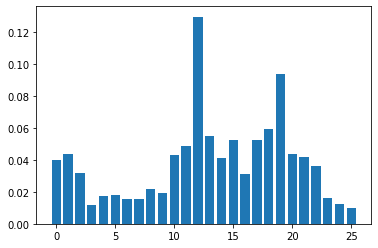

In [ ]:
from matplotlib import pyplot

#calculating feature importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
# load the test day data
data_test = np.load('/content/drive/My Drive/kddworkshop/fulldata/test_138_day.npz')

passive =1

#load common data
latlon_test = data_test['latlon']
iff_test = data_test['iff']

# if passive ==1:
x_t_test = data_test['viirs']
y_t_test = data_test['label']
# else:
# x_s_test = data_test['calipso']
# y_s_test = data_test['label']
    
inds_test,vals_test = np.where(y_t_test>0)

# process common data
Latlon_test = latlon_test[inds_test]
Iff_test = iff_test[inds_test]

Y_t_test = y_t_test[inds_test]
X_t_test = x_t_test[inds_test]

# 0 =< SZA <= 83
print('original X_t_test: ', X_t_test.shape)
rows_test = np.where((X_t_test[:,0] >= 0) & (X_t_test[:,0] <= 83) & (X_t_test[:,15] > 100) & (X_t_test[:,15] < 400) & (X_t_test[:,16] > 100) & (X_t_test[:,16] < 400) & (X_t_test[:,17] > 100) & (X_t_test[:,17] < 400) & (X_t_test[:,18] > 100) & (X_t_test[:,18] < 400) & (X_t_test[:,19] > 100) & (X_t_test[:,19] < 400) & (X_t_test[:,10] > 0))
print("rows_test:", rows_test)
print("rows_test.shape:", len(rows_test))

Latlon_test = Latlon_test[rows_test]
Iff_test = Iff_test[rows_test]

Y_t_test = Y_t_test[rows_test]
X_t_test = X_t_test[rows_test]

# X_s_test = np.nan_to_num(X_s_test)
X_t_test = np.nan_to_num(X_t_test)

print('after SZA X_t_test: ', X_t_test.shape)
# print('after SZA X_s_test: ', X_s_test.shape)


#concanate common data
X_t_test = np.concatenate((X_t_test, Latlon_test, Iff_test), axis=1)
# X_s_test = np.concatenate((X_s_test, Latlon_test, Iff_test), axis=1)
# print (X_s_test.shape)
print (X_t_test.shape)

# feature scaling
X_t_test=sc_X.transform(X_t_test)
print (X_t_test.shape)



original X_t_test:  (144703, 20)
rows_test: (array([  1502,   1503,   1504, ..., 144700, 144701, 144702]),)
rows_test.shape: 1
after SZA X_t_test:  (60487, 20)
(60487, 26)
(60487, 26)


In [ ]:
# 2. TODO: Sahara, add the RF prediction on the testing 144 data 
#Testing the model on testing data

y_pred = rf.predict(X_t_test)
print (rf.score(X_t_test, Y_t_test))



0.6455271380627242


In [ ]:
# score = model.evaluate(x_test_pt_test, Y_t_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# print('Test score:', score)
# predict_result = model.predict_proba(x_test_pt);
# print (predict_result)
# from sklearn.metrics import roc_auc_score
# roc_auc_score(y_test, predict_result)